<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/pytorch02Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import requests
from pathlib import Path

# download helper functions from Learn Pytorch repo (if its not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


# 1. Binary classification using Scikit-Learns make_moons() function

## 1.1 create toy moons binary dataset

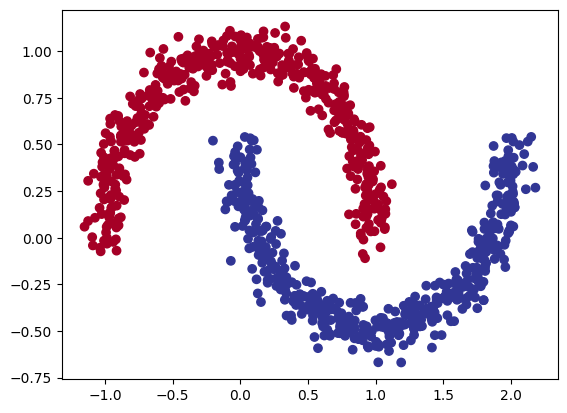

In [70]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# make 1000 samples
n_samples = 1000

X, y = make_moons(n_samples,
                  noise=0.07,
                  random_state=42)

# visualize
plt.scatter(X[:, 0],X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [71]:
# convert data into tensors
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)
X_train[:10], y_train[:10]

(tensor([[ 2.0144,  0.2466],
         [-1.0187,  0.4045],
         [-0.1252,  1.0580],
         [-0.0977,  0.9901],
         [ 0.3807, -0.2384],
         [-0.2101,  0.9271],
         [ 0.5744, -0.3417],
         [ 0.1392,  0.0353],
         [ 0.5074,  0.8867],
         [-0.9538,  0.1589]]),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

## 1.2 Build a binary classification model in pytorch

In [72]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [73]:
# build a binary classification model that utilizes non-linearity
class BinaryClassificationModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multiclass classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features / classes
            hidden_units (int): number of hidden units between layers, default 8
        """
        super().__init__()
        super().__init__()

        self.layer1 = nn.Linear(in_features=input_features,
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

# create an insance of the model/
model_0 = BinaryClassificationModelV0(input_features=2,
                                      output_features=1,
                                      hidden_units=16).to(device)
model_0


BinaryClassificationModelV0(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

## 1.3 Create a loss function and an optimizer

In [74]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)



In [75]:
!pip install torchmetrics

In [76]:
# accuracy function
from torchmetrics import Accuracy
acc_fn = Accuracy(task="binary")

## 1.4 Creating a training and testing loop

### 1.4.1 converting our raw logits to pred_probs to pred labels

In [77]:
# raw data to logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device)).squeeze()
print("y_logits: ", y_logits[:10])

# convert our logits to pred probs
y_pred_probs = torch.sigmoid(y_logits)
print("y_pred_probs", y_pred_probs[:10])

# convert y_pred_probs to pred_labels
y_pred_labels = torch.round(y_pred_probs)
print("y_pred_labels", y_pred_labels[:10])

y_logits:  tensor([-0.1451, -0.1832, -0.1494, -0.2096, -0.1906, -0.2100, -0.1627, -0.1553,
        -0.1320, -0.1863])
y_pred_probs tensor([0.4638, 0.4543, 0.4627, 0.4478, 0.4525, 0.4477, 0.4594, 0.4613, 0.4670,
        0.4536])
y_pred_labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### 1.4.2 building a training and testing loop

In [80]:
# set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 1000

# put the data into a target device
X_train, y_train =  X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# for an epoch in a range:
for epoch in range(epochs):
    # in model.train
    model_0.train()
    # do the forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    # calculate the loss
    loss = loss_fn(y_logits,
                   y_train)
    acc = acc_fn(y_pred_labels,
                 y_train.int())
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step step
    optimizer.step()
    # let's test
    # in model.eval
    model_0.eval()
    # with torch.inference_mode:
    with torch.inference_mode():
        # do the forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred_labels = torch.round(torch.sigmoid(test_logits))
        # calculate the loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = acc_fn(test_pred_labels,
                          y_test.int())
    # print out whats happenin
    if epoch%100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}   |   Test loss: {test_loss:.5f}, Test acc: {test_acc:2f}")

Epoch: 0, Loss: 0.05162, Acc: 0.99%   |   Test loss: 0.04718, Test acc: 0.995000
Epoch: 100, Loss: 0.03549, Acc: 1.00%   |   Test loss: 0.03137, Test acc: 1.000000
Epoch: 200, Loss: 0.02607, Acc: 1.00%   |   Test loss: 0.02247, Test acc: 1.000000
Epoch: 300, Loss: 0.02023, Acc: 1.00%   |   Test loss: 0.01706, Test acc: 1.000000
Epoch: 400, Loss: 0.01635, Acc: 1.00%   |   Test loss: 0.01352, Test acc: 1.000000
Epoch: 500, Loss: 0.01363, Acc: 1.00%   |   Test loss: 0.01108, Test acc: 1.000000
Epoch: 600, Loss: 0.01163, Acc: 1.00%   |   Test loss: 0.00931, Test acc: 1.000000
Epoch: 700, Loss: 0.01009, Acc: 1.00%   |   Test loss: 0.00798, Test acc: 1.000000
Epoch: 800, Loss: 0.00888, Acc: 1.00%   |   Test loss: 0.00694, Test acc: 1.000000
Epoch: 900, Loss: 0.00791, Acc: 1.00%   |   Test loss: 0.00610, Test acc: 1.000000


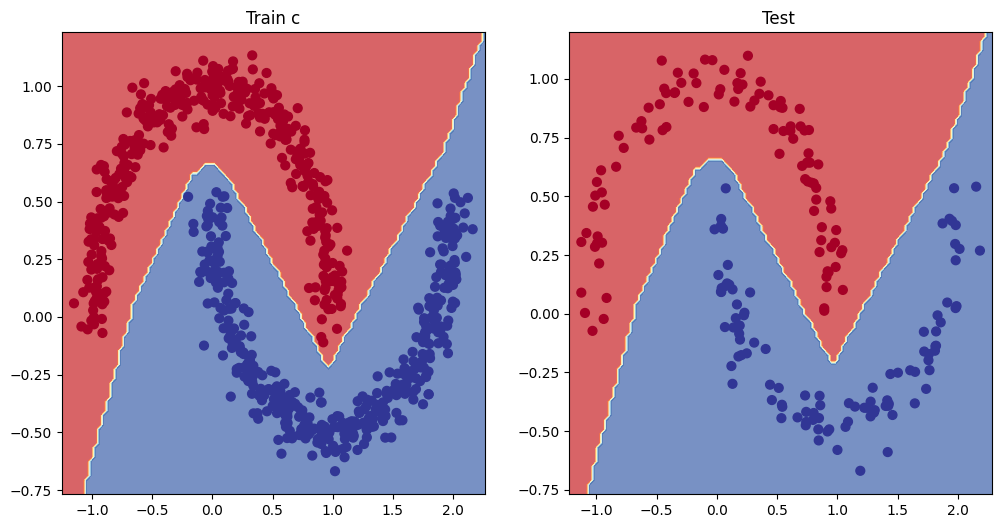

In [81]:
# plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train c")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test ")
plot_decision_boundary(model_0, X_test, y_test)

## 1.5 Making and evaluating predictions